In [1]:
import matplotlib.pyplot as plt
import numpy as np
import math
import scipy as sp
from scipy import signal
from lea_utils import APRBS,plot_states_double, norm_values
from lea_utils import MLEA, ModeloLEA
#%matplotlib tk  #Desabilita exibição de plot inline no notebook

In [2]:
# =========================================================================
#  Define as entradas do BCS LEA   
# =========================================================================
# Instancia um objeto BCS LEA com dados experimentais
intervalo_horas=(0,7) #Janela de simulação em horas escolhida com base no histórico de dados
filepath="./dados_experimentais/Dados_BCSLEA_20210818.mat"
BCS_LEA=MLEA(filepath,intervalo_horas) #Instanciamento do
fk,zc,pman,pres=BCS_LEA.get_exo_values() # Armazenamento dos valores das exógenas
pbh,pwh,q=BCS_LEA.get_ss_values() # Armazenamento dos valores dos estados
u_0=np.array([fk[0],zc[0],pman[0],pres[0]]) #Valor inicial de entrada
u_exp=np.array([fk,zc,pman,pres])#Empacotamento entradas exógenas experimentais
x_0=np.array([pbh[0],pwh[0],q[0]])#Empacotamento valor inicial para os estados
xss=x_0;uss=u_0 #Iniciar a simulação - nos valores iniciais
#####################################################
nsim=BCS_LEA.nsim# Time-steps para simulação
ts=BCS_LEA.ts #Sampling tim
tempo_hora = np.arange(0,nsim*ts,ts)/3600 # vetor de tempo em horas
# BCS_LEA.plot_exogenous() #método para plotagem das curvas de entradas exógenas
# BCS_LEA.plot_states() #método para plotagem das curvas de estados

0


In [3]:
####################
#Obter os fatores de escalonamento para simulação
xc,x0=norm_values()
####################
xssn = (xss-x0)/xc
#### Transformação para unidades de engenharia (bar, m3/h)
xscale=np.array([1/1e5,1/1e5,3600])
####


In [4]:
Modelo=ModeloLEA(xssn)

In [5]:
Modelo.Eq_Estado(xssn,uss)

DM([-1.57841, -0.615181, -1.5272])

In [6]:
Modelo.sea_nl(xssn,uss)

(DM(128211), DM(68.8334))

In [7]:
print(xssn)
Modelo.regime_estacionario()(xssn,uss)


[[0.69708344 0.3439367  0.27783165]]

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************



DM([0.679757, 0.325971, 0.295222])

### Simulação

In [25]:
uk_1=u_exp.T
print("Simulação iniciada")

xssn=Modelo.regime_estacionario()(xssn,uss) #valor inicial normalizado
xpk=Modelo.PredictionModel(ts)(xssn,uss)
xpks=xpk*xc+x0
#Inicialização do vetor de estados
Xk=xpks
#Inicialização do vetor de entradas exogenas
Uk= np.array(uss).reshape(1,4)
xi=tempo_hora
for k in range(1,nsim):
    xpk = Modelo.PredictionModel(ts)(xpk,uk_1[k:k+1,:])
    xpks=xpk*xc+x0
    Xk = np.concatenate((Xk,xpks),axis=0) #desnormalizar x e preencher vetor
    Uk = np.concatenate((Uk,uk_1[k:k+1,:]),axis=0)
print("Ok.simulação concluida")

print(Xk.shape)

Simulação iniciada
Ok.simulação concluida
(252, 3)


In [ ]:
BCS_LEA.plot_exogenous()

### Resultados

1e-05
1e-05
3600


ValueError: x and y must have same first dimension, but have shapes (252,) and (3,)

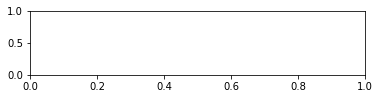

In [26]:
sim_states=[Xk[0,:],Xk[1,:],Xk[2,:]]
exp_states=[pbh,pwh,q]
# estados simulados vs experimentais
plot_ss=plot_states_double(tempo_hora,sim_states,exp_states)


In [ ]:
print('teste')

teste


<ipython-input-26-a3f713936d6c>:23: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig1.show()


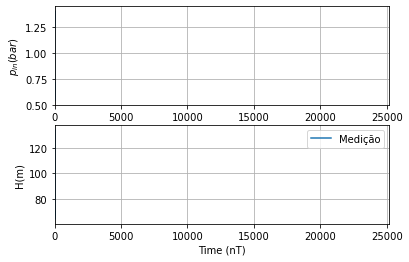

In [ ]:
fig1=plt.figure()
label = [r'$p_{in}(bar)$','H(m)','P','I','qc','qr' ];
for iy in range(0,npv):
    ax = fig1.add_subplot(npv,1,iy+1)
    #print(iy)
    if iy == 0: # Pin
        ax.plot(xi,(Yk[iy,:].T)/1e5, label='Medição')
        #ax.plot(xi,Ymk[iy,:].T/1e5, label='EKF')
        ax.set_ylabel(label[iy])
        ax.set(xlim=(xi[0], nsim*ts))
       # ax.set(ylim=(40,62))
        plt.grid(True)
    else: # H
        ax.plot(xi,Yk[iy,:].T, label='Medição')
        #ax.plot(xi,Ymk[iy,:].T,label='EKF')
        ax.set_ylabel(label[iy])
        ax.set(xlim=(xi[0], nsim*ts))
       # ax.set(ylim=(580, 850))
        plt.grid(True)
#ax.plot(xi,Yk[2,:].T, label='EKF')
ax.legend();
ax.set_xlabel('Time (nT)')
fig1.show()


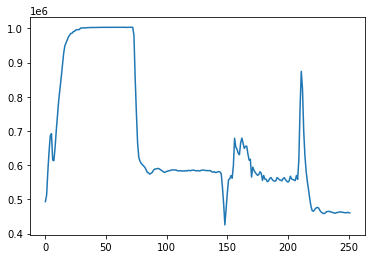

In [ ]:
plt.plot(Xk[1,:])

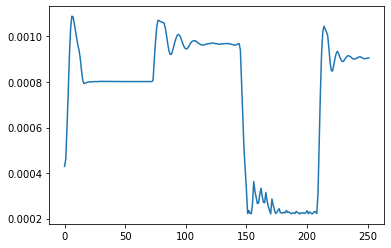

In [ ]:
plt.plot(Xk[2,:])

In [ ]:
# #exec(compile(open('envelope.py', "rb").read(), 'envelope.py', 'exec')) #% Roda arquivo com parâmetros do modelo BCS
# fig4,ax4=plt.subplots()
# plt.grid(True)
# #BCS['Envelope']['fig'](ax4); # grafico do envelope
# #
# # Evolução dentro do envelope
# ax4.plot(Xk[2,0:].T*3600,Yk[1,0:].T,'--k')
# ax4.plot(Xk[2,0]*3600,Yk[1,0],'o')#,'MarkerFaceColor',[0,1,0],'MarkerEdgeColor',[0,0,0])
# ax4.plot(Xk[2,-1]*3600,Yk[1,-1],'o')#,'MarkerFaceColor',[1,0,0],'MarkerEdgeColor',[0,0,0])
# ax4.annotate('t=0',
#              xy=(float(Xk[2,0]*3600),float(Yk[1,0])),
#              xytext=(float(Xk[2,0]*3600)-5,float(Yk[1,0])+10),
#              arrowprops=dict(facecolor='green', shrink=0.01))

# ax4.annotate('t='+str(nsim),
#              xy=(float(Xk[2,-1]*3600),float(Yk[1,-1])),
#              xytext=(float(Xk[2,-1]*3600)-7,float(Yk[1,-1])+10),
#              arrowprops=dict(facecolor='red', shrink=0.01))
# plt.show()



In [ ]:
#np.savez('LEA_data_train-f.npz', t=xi, x1=Xk[0,:].T,x2=Xk[1,:].T,x3=Xk[2,:].T,zc=zc2,f=f2,pm=pm2,pr=pr2)

In [ ]:
def ler_dados(str):
    with open(str, 'r') as f:
        d = f.readlines()
        epocas = np.zeros(len(d));
        tau = np.zeros(len(d));
        j = 0;
        data = []
        for i in d:
            k = i.rstrip().split(" ")
            data.append([float(i) if is_float(i) else i for i in k])
            epocas[j] = float(k[0])
            tau[j] = float(k[1])
            j += 1;
    
    return tau, epocas


In [ ]:
qcc/qc

NameError: name 'qcc' is not defined